In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [24]:
train = pd.read_csv('./data/sales_train.csv')
test = pd.read_csv('./data/test.csv')

shops = pd.read_csv('./data/shops.csv')
item_cats = pd.read_csv('./data/item_categories.csv')
items = pd.read_csv('./data/items.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

# Validate Data

In [25]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [26]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [28]:
train.isnull().sum(), train.isna().sum()

(date              0
 date_block_num    0
 shop_id           0
 item_id           0
 item_price        0
 item_cnt_day      0
 dtype: int64, date              0
 date_block_num    0
 shop_id           0
 item_id           0
 item_price        0
 item_cnt_day      0
 dtype: int64)

## Downcasting to reduce the size by half

In [29]:
def downcast_dtype(df):
    float_cols = [col for col in df if df[col].dtype == 'float64']
    int_cols = [col for col in df if df[col].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [30]:
train = downcast_dtype(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float32
item_cnt_day      float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB


# Data Exploration

In [31]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
grouped.head()

,shop_id,date_block_num,item_cnt_day
0,0,0,5578.0
1,0,1,6127.0
2,1,0,2947.0
3,1,1,3364.0
4,2,0,1146.0


## Plot Shops and respective item sales over time

In [32]:
len(grouped["shop_id"].unique())

60

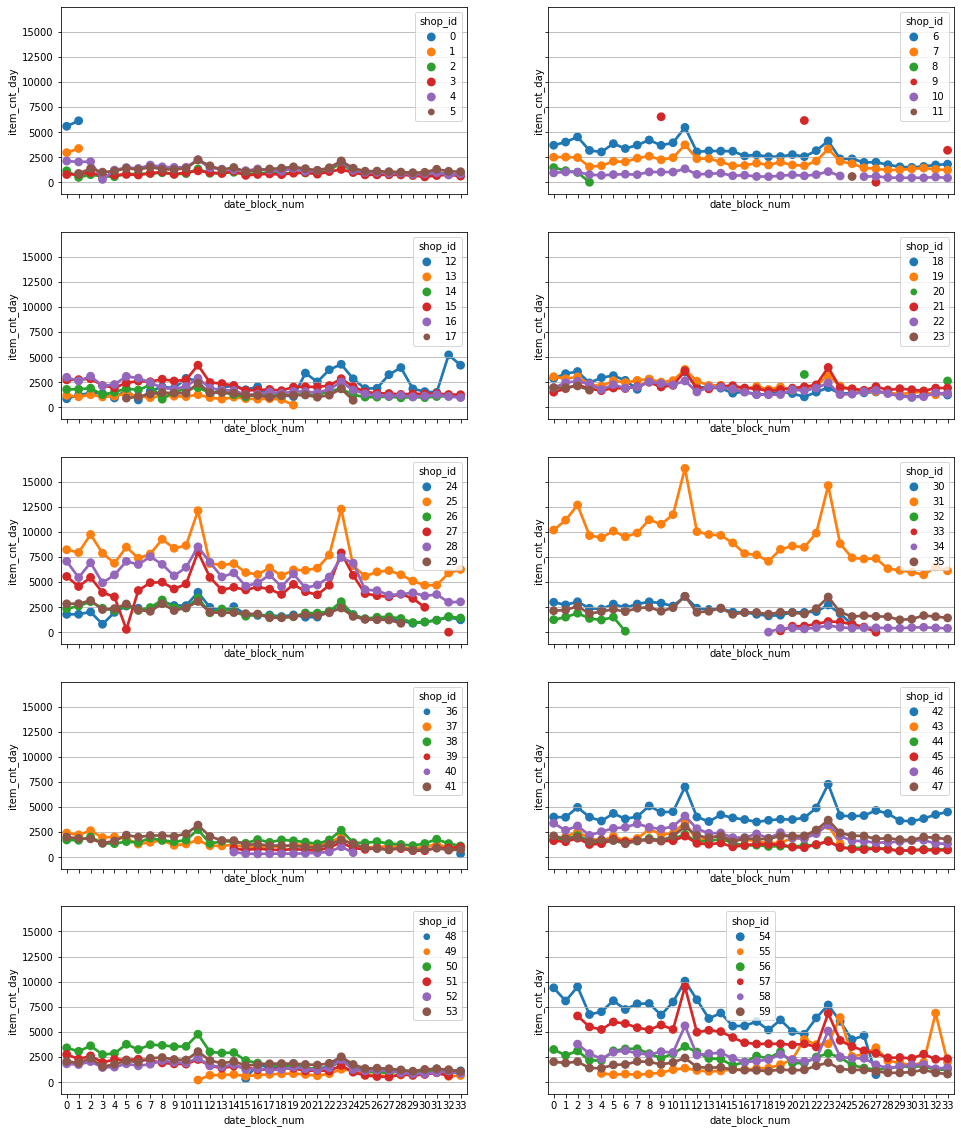

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
count = 0

for i in range(5):
    for j in range(2):
        shop_ids = np.logical_and(count * 6 <= grouped['shop_id'], grouped['shop_id'] < (count + 1) * 6)
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[shop_ids], ax=axes[i][j])
        count += 1

In [34]:
sales_by_item = train.pivot_table(index=['item_id'], values=['item_cnt_day'], columns=['date_block_num'], aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item.columns = sales_by_item.columns.droplevel().map(str) # need to map(str) for indexing
sales_by_item = sales_by_item.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item.columns.values[0] = 'item_id'
sales_by_item.head()

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


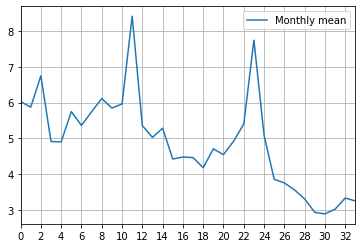

In [35]:
sales_by_item.mean()[1:].plot(legend=True, label='Monthly mean', xticks=range(0, 34, 2));

### Sales seem to spike in November
### Find outdated items and closed shops. If something has 0 sales volume in the last 6 month we consider it closed / outdated

In [36]:
outdated_items = sales_by_item[sales_by_item.loc[:,'27':].sum(axis=1) == 0]
len(outdated_items)

12391

In [37]:
sales_by_shop = train.pivot_table(index=['shop_id'], values=['item_cnt_day'], columns=['date_block_num'], aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop.columns = sales_by_shop.columns.droplevel().map(str)
sales_by_shop = sales_by_shop.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop.columns.values[0] = 'shop_id'

sales_by_shop.head()

,shop_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,5578,6127,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2947,3364,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1146,488,753,583,553,832,807,875,945,...,987,907,762,859,843,804,785,942,822,727
3,3,767,798,959,647,710,784,721,890,1026,...,977,738,741,740,731,672,535,666,745,613
4,4,2114,2025,2060,285,1211,1464,1378,1713,1536,...,1188,980,978,899,893,793,842,947,732,831


In [38]:
closed_shops = sales_by_shop[sales_by_shop.loc[:,'27':].sum(axis=1) == 0]
len(closed_shops)

11

### Find outliers

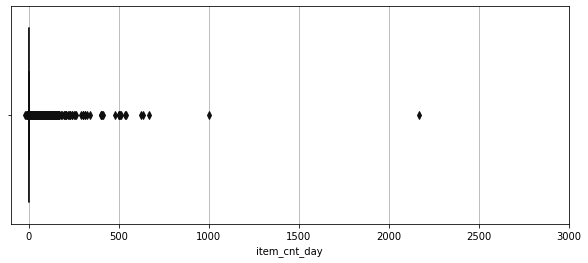

In [39]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train['item_cnt_day'], color=(0.2,0,0));

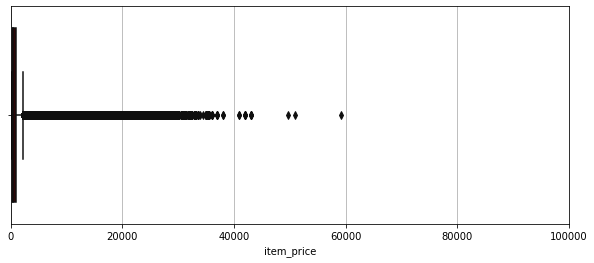

In [40]:
plt.figure(figsize=(10,4))
plt.xlim(0, 100000)
sns.boxplot(x=train['item_price'], color=(0.2,0,0));

In [41]:
sale_outliers = train['item_id'][train['item_cnt_day'] > 1000].unique()
price_outliers = train['item_id'][train['item_price'] > 50000].unique()

In [42]:
(train['item_cnt_day'] < 0).sum() # most likely returns

7356

In [43]:
(train['item_price'] < 0).sum() # negativ price doesn't make sense so we remove it

1

In [44]:
(train['item_price'] == 0).sum()

0

In [45]:
train = train[train['item_price'] > 0]

In [46]:
'Outdated items in test set:', len(test[test['item_id'].isin(outdated_items['item_id'])])

('Outdated items in test set:', 6888)

In [47]:
'Closed shops in test set:', len(test[test['shop_id'].isin(closed_shops['shop_id'])])

('Closed shops in test set:', 0)

In [48]:
'Sale volume outliers in test set:', len(test[test['item_id'].isin(sale_outliers)])

('Sale volume outliers in test set:', 42)

In [49]:
'Price outliers in test set:', len(test[test['item_id'].isin(price_outliers)])

('Price outliers in test set:', 42)